# 10 classes, Hellinger distance, MNIST, final graphs?

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from keras.datasets import mnist
import itertools
import codecs
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action = 'ignore', category = FutureWarning)

Using TensorFlow backend.


In [2]:
def factorial(n):
    if n == 0:
        return 1
    elif n > 0:
        return n*factorial(n - 1)

In [3]:
# entropy labelling
def tsallis_label(q, probas, s_cls):
    elements = np.power(probas, q - 1)
    # thrshld in tsallis entropy model
    ts_thrshld = np.sum(np.power(probas, q))
    if q < 1:
        labels = [s_cls[i] for i, e in enumerate(elements) if e < ts_thrshld]
    else:
        labels = [s_cls[i] for i, e in enumerate(elements) if e > ts_thrshld]
    return labels

In [4]:
# 1/M labelling
def oneMth_label(probas, s_cls):
    # 1/M
    thrshld = 1/len(s_cls)
    labels = [s_cls[i] for i, pk in enumerate(probas) if pk > thrshld]
    return labels

In [5]:
def shannon_label(probas, s_cls):
    info_con = (-1)*np.log2(probas)
    # entropy
    Hp = np.sum(np.multiply(probas, info_con))
    if isnan(Hp):
        labels = [s_cls[np.argmax(probas)]]
    else:
        labels = [s_cls[i] for i, Ipk in enumerate(info_con) if Ipk <= Hp]
    return labels

In [23]:
# labelling and evaluating them
def info_trans_scoring(q, classes, orig_A, lim_A, dataset):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    if (dataset == "mnist"):
        a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    else:
        a1_model = LR(max_iter = 300).fit(trn_imgs[:orig_A], trn_labels[:orig_A])
        
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # labelling
    if (q == 0): # 1/M
        mul_labels = [oneMth_label(probas, s_cls) for probas in a1_probas]
    elif (q == 1): # shannon
        mul_labels = [shannon_label(probas, s_cls) for probas in a1_probas]
    else: # regular tsallis
        mul_labels = [tsallis_label(q, probas, s_cls) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power((np.sqrt(probas[s_cls.index(label)]) - np.sqrt(u_dist)), 2)
    
    lnum = 0
    for labels in mul_labels:
         lnum += len(labels)
    
    return (lnum/lim_A, np.sqrt(score)/np.sqrt(2))

In [19]:
# fop top-r (1.2, 1.4, 1.6, 1.8)
from sklearn.model_selection import train_test_split

# labelling and evaluating them
def info_trans_scoring_3(part, classes, orig_A, lim_A, dataset):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    # generate an annotator
    if (dataset == "mnist"):
        ann_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    else:
        ann_model = LR(max_iter = 300).fit(trn_imgs[:orig_A], trn_labels[:orig_A])

    # labelling
    f_imgs, s_imgs, f_labels, s_labels = train_test_split(trn_imgs[orig_A:orig_A + lim_A], trn_labels[orig_A:orig_A + lim_A], test_size = part/100)
    # top-1
    f_ann_proba = ann_model.predict_proba(f_imgs)
    ord_labels = [topk_label(probas, s_cls, 1) for probas in f_ann_proba]
    # top-2
    s_ann_proba = ann_model.predict_proba(s_imgs)
    top2_labels = [topk_label(probas, s_cls, 2) for probas in s_ann_proba]
    # concat top-1 results and top-2 results
    ann_probas = ann_model.predict_proba(f_imgs + s_imgs)
    mul_labels = ord_labels + top2_labels
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, ann_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power((np.sqrt(probas[s_cls.index(label)]) - np.sqrt(u_dist)), 2)
            
    lnum = 0
    for labels in mul_labels:
         lnum += len(labels)
    
    return (lnum/lim_A, np.sqrt(score)/np.sqrt(2))

In [62]:
# loading MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

### q = -10, -1.0, -0.5, -0.1, 0, 0.1, 1.0 

In [31]:
# main measurement
from math import isnan # for shannon

classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)
dataset = "mnist"

q_list = [-10, -1.0, -0.5, -0.1, 0, 0.1, 1]
results = [info_trans_scoring(q, classes, orig_A1, lim_A1, dataset) for q in q_list]

lnums = [e[0] for e in results]
hell_values = [e[1] for e in results]
print(lnums)
print(hell_values)

/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """


[7.871, 5.3105, 3.375, 1.464, 1.2235, 1.1525, 1.0505]
[34.55525916103137, 31.515281268279736, 26.504816333360264, 9.885849848745657, 2.567830217165451, 1.4024960668440367, 2.9529449627044273]


### q = +inf (Top-1)

In [39]:
# top-k labelling
def topk_label(probas, s_cls, k):
    l_indexes = probas.argsort()[::-1][:k]
    labels = [s_cls[i] for i in l_indexes]
    return labels

# labelling and evaluating them
def info_trans_scoring_2(k, classes, orig_A, lim_A, dataset):
    s_cls = classes

    # extract dataset of chosen classes
    trn_imgs = [img for i, img in enumerate(train_imgs) if train_labels[i] in s_cls]
    trn_labels = [label for label in train_labels if label in s_cls]

    # generate an annotator
    # generate an annotator
    if (dataset == "mnist"):
        a1_model = LR().fit(trn_imgs[:orig_A], trn_labels[:orig_A])
    else:
        a1_model = LR(max_iter = 300).fit(trn_imgs[:orig_A], trn_labels[:orig_A])
        
    a1_probas = a1_model.predict_proba(trn_imgs[orig_A:orig_A + lim_A])

    # entropy labelling
    mul_labels = [topk_label(probas, s_cls, k) for probas in a1_probas]
    
    # scoring info transmission
    score = 0
    for labels, probas in zip(mul_labels, a1_probas):
        u_dist = 1/len(labels)
        for label in labels:
            score += np.power((np.sqrt(probas[s_cls.index(label)]) - np.sqrt(u_dist)), 2)
    
    lnum = 0
    for labels in mul_labels:
         lnum += len(labels)
    
    return (lnum/lim_A, np.sqrt(score)/np.sqrt(2))

In [11]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)
dataset = "mnist"

print(info_trans_scoring_2(1, classes, orig_A1, lim_A1, dataset))

3.7107261746317772


### q = -inf (Top-9)

In [12]:
print(info_trans_scoring_2(9, classes, orig_A1, lim_A1, dataset))

35.43164316829221


## Tsallis

In [63]:
hell_d = [35.43164316829221, 34.55525916103137, 31.515281268279736, 26.504816333360264, 9.885849848745657, 2.567830217165451, 1.4024960668440367, 2.9529449627044273, 3.7107261746317772]
lnums = [9.0, 7.871, 5.3105, 3.375, 1.464, 1.2235, 1.1525, 1.0505, 1.0]

## Top-k

In [64]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)

topk_results = [info_trans_scoring_2(k, classes, orig_A1, lim_A1, dataset) for k in range(9, 0, -1)]
topk_lnums = [e[0] for e in topk_results]
topk_hell_values = [e[1] for e in topk_results]

## two graphs merged

W0708 16:47:49.017043 139760905914176 legend.py:1282] No handles with labels found to put in legend.


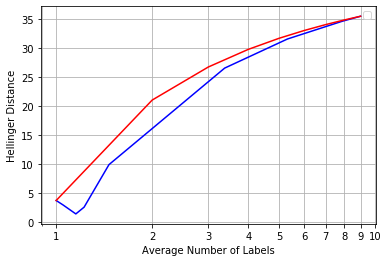

In [65]:
fig = plt.figure()
ax = fig.add_subplot(111)
pos = [i + 1 for i in range(10)] 
ticks = [str(e) for e in pos]
ax.set_xscale('log')
ax.set_xticks(pos)
ax.set_xticklabels(ticks)
plt.xlabel("Average Number of Labels")
plt.ylabel("Hellinger Distance")
plt.legend(loc = 'best')
plt.grid(which = 'both')

plt.plot(lnums, hell_d, color = 'b', label = "tsallis")
plt.plot([k + 1 for k in range(9)], topk_hell_values[::-1], color = 'r', label = "top-k")
fig.savefig("tsallis-vs-top-k_mnist.pdf")

# 10 classes, Hellinger distance, Fashion-MNIST

In [66]:
from keras.datasets import fashion_mnist
# loading fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_imgs = np.array([x.ravel() for x in train_images])
test_imgs = np.array([y.ravel() for y in test_images])

### q = -10, -1.0, -0.5, -0.1, 0, 0.1, 1.0 

In [55]:
# main measurement
from math import isnan # for shannon

classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)

q_list = [-10, -1.0, -0.5, -0.1, 0, 0.1, 1]
results = [info_trans_scoring(q, classes, orig_A1, lim_A1, dataset) for q in q_list]

lnums = [e[0] for e in results]
hell_values = [e[1] for e in results]
print(lnums)
print(hell_values)

/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/home/k.goto/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """


[7.39, 5.648, 3.759, 1.646, 1.2905, 1.1935, 1.07]
[33.81488149888806, 31.831040140800596, 27.610787797775682, 12.068380301185307, 3.06998522427623, 1.5501536602583712, 3.2000566804065045]


### q = +inf (Top-1)

In [56]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)
dataset = "fmnist"

print(info_trans_scoring_2(1, classes, orig_A1, lim_A1, dataset))

(1.0, 4.162116489974839)


### q = -inf (Top-9)

In [57]:
print(info_trans_scoring_2(9, classes, orig_A1, lim_A1, dataset))

(9.0, 35.141002116644025)


## Tsallis

In [67]:
hell_d = [35.141002116644025, 33.81488149888806, 31.831040140800596, 27.610787797775682, 12.068380301185307, 3.06998522427623, 1.5501536602583712, 3.2000566804065045, 4.162116489974839]
lnums = [9.0, 7.39, 5.648, 3.759, 1.646, 1.2905, 1.1935, 1.07, 1.0]

## Top-k

In [ ]:
# main measurement
classes = [i for i in range(10)]
orig_A1, lim_A1 = 2000, 2000
fact_10 = factorial(10)
dataset = "fmnist"

topk_results = [info_trans_scoring_2(k, classes, orig_A1, lim_A1, dataset) for k in range(9, 0, -1)]
topk_lnums = [e[0] for e in topk_results]
topk_hell_values = [e[1] for e in topk_results]

## two graphs merged

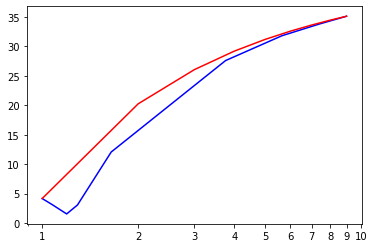

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)
pos = [i + 1 for i in range(10)] 
ticks = [str(e) for e in pos]
ax.set_xscale('log')
ax.set_xticks(pos)
ax.set_xticklabels(ticks)
plt.xlabel("Average Number of Labels")
plt.ylabel("Hellinger Distance")
plt.legend(loc = 'best')
plt.grid(which = 'both')

plt.plot(lnums, hell_d, color = 'b', label = "tsallis")
plt.plot([k + 1 for k in range(9)], topk_hell_values[::-1], color = 'r', label = "top-k")